In [1]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys

sys.path.append(os.path.abspath(os.path.join("../")))

In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.metrics
import glob
import datetime as dt
from sklearn.metrics import r2_score
from numba import jit
from tqdm.auto import tqdm

import helper_libraries.results_tools as results_tools

# Example

## Load data

In [3]:
# Load data
forecast_oss_df, forecast_ins_df, _ = results_tools.load_model_results(overnight=False, oos_periods=2, debug = True, asset = 'ff__mkt')
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

Loading the following model results...
--------------------------------------------------
Folder           main
Overnight       False
OOSPeriods          2
Predictors        All
Notes            Done
Asset         ff__mkt
--------------------------------------------------


## R-Squared

In [4]:
def compute_rsquared(truth, pred):
    return 1 - np.sum(np.square(truth-pred))/np.sum(np.square(truth))

In [5]:
def get_metrics(fret_df, forecast_oss_df, forecast_ins_df):

    # Get true values
    forecast_oss_df["truth"] = fret_df.iloc[:,0]
    forecast_ins_df["truth"] = fret_df.iloc[:,0]

    # Filter
    forecast_oss_df = forecast_oss_df.loc['2004':]
    forecast_ins_df = forecast_ins_df.loc['2004':]
    fret_df = fret_df.loc['2004':]

    # Set up dataframe with metrics
    model_names = [
        x for x in ["_".join(col.split("_")[1:]) for col in forecast_oss_df.columns] if len(x) > 0
    ]
    metrics_df = pd.DataFrame([], index=model_names)

    # Fill in R2 estimates
    for col in model_names:
        metrics_df.loc[col, "R2_ins"] = compute_rsquared(
            forecast_ins_df["truth"], forecast_ins_df["ins_" + col]
        )
        metrics_df.loc[col, "R2_oss"] = compute_rsquared(
            forecast_oss_df["truth"], forecast_oss_df["oss_" + col]
        )

    # metrics_df = metrics_df.applymap(lambda x: np.nan if np.abs(x) > 10 else x)
    metrics_df["R2_diff"] = metrics_df["R2_oss"] - metrics_df["R2_ins"]
    
    return metrics_df

<AxesSubplot:>

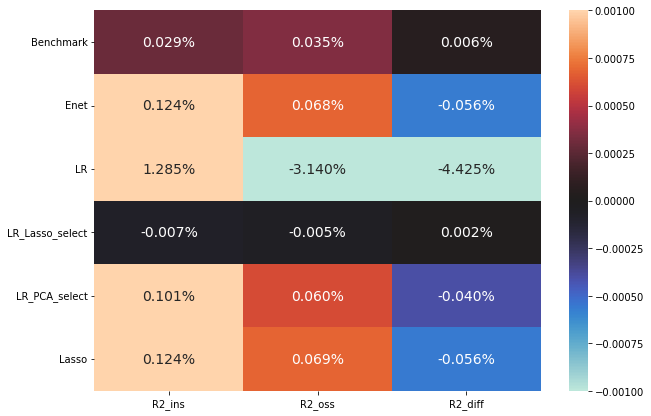

In [6]:
metrics_df = get_metrics(fret_df, forecast_oss_df, forecast_ins_df)

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(
    metrics_df,
    cmap="icefire",
    vmin=-0.1 / 100,
    center=0,
    vmax=0.1 / 100,
    annot=True,
    fmt=".3%",
    annot_kws={"fontsize": 14},
)

# R-Squared versus Frequency

In [7]:
metrics_hf_df = get_metrics(fret_df, forecast_oss_df, forecast_ins_df)
metrics_hf_df

,R2_ins,R2_oss,R2_diff
Benchmark,0.000294,0.000353,0.000059
Enet,0.001243,0.000680,-0.000563
LR,0.012848,-0.031399,-0.044247
LR_Lasso_select,-0.000073,-0.000055,0.000019
LR_PCA_select,0.001007,0.000605,-0.000402
Lasso,0.001243,0.000687,-0.000556


In [8]:
print(metrics_hf_df.to_latex(float_format = '{0:.3%}'.format))

\begin{tabular}{lrrr}
\toprule
{} &  R2\_ins &  R2\_oss &  R2\_diff \\
\midrule
Benchmark       &  0.029\% &  0.035\% &   0.006\% \\
Enet            &  0.124\% &  0.068\% &  -0.056\% \\
LR              &  1.285\% & -3.140\% &  -4.425\% \\
LR\_Lasso\_select & -0.007\% & -0.005\% &   0.002\% \\
LR\_PCA\_select   &  0.101\% &  0.060\% &  -0.040\% \\
Lasso           &  0.124\% &  0.069\% &  -0.056\% \\
\bottomrule
\end{tabular}



## Hourly data

In [9]:
# Load hourly data
forecast_hourly_oss_df, forecast_hourly_ins_df, _ = results_tools.load_model_results(folder_name = 'main_hour')

In [10]:
# Setup true values for hourly
concat_data_df = fret_df.copy()
concat_data_df["date"] = pd.to_datetime(concat_data_df.index.date)
concat_data_df["time"] = concat_data_df.index.time

Y = pd.concat(
    [
        concat_data_df
        .rolling(4, win_type=None)
        .mean()
        .shift(-3)
        .copy(),
        concat_data_df.time,
    ],
    axis=1,
)
Y = Y[(Y.time < dt.time(15, 15)) == True]
Y = Y.drop(["time"], axis=1)

In [12]:
metrics_hourly_df = get_metrics(Y, forecast_hourly_oss_df, forecast_hourly_ins_df)
metrics_hourly_df

,R2_ins,R2_oss,R2_diff
Benchmark,-0.001576,-0.001372,0.000203
Enet,0.000169,-0.000353,-0.000522
LR,0.016939,-0.087806,-0.104745
LR_Lasso_select,-0.000176,-0.000070,0.000106
LR_PCA_select,0.003000,0.000725,-0.002275
Lasso,0.000236,-0.000163,-0.000399


## Daily data

In [13]:
# Load daily data
forecast_daily_oss_df, forecast_daily_ins_df, _ = results_tools.load_model_results(folder_name = 'main_daily')

In [14]:
# Setup true values for daily
Y = (
    concat_data_df
    .groupby(pd.Grouper(freq="1d"))
    .mean()
    .rolling("1d", win_type=None)
    .mean()
    .dropna()
)

Y["date"] = pd.to_datetime(Y.index.date)
Y = Y.drop(["date"], axis=1)

In [15]:
metrics_daily_df = get_metrics(Y, forecast_daily_oss_df, forecast_daily_ins_df)
metrics_daily_df

,R2_ins,R2_oss,R2_diff
Benchmark,-0.005781,-0.005152,0.000629
Enet,0.002561,-0.001002,-0.003564
LR,-0.035172,-17.397107,-17.361935
LR_Lasso_select,0.000907,0.000816,-0.000091
LR_PCA_select,-0.005210,-0.002022,0.003189
Lasso,0.001209,-0.000419,-0.001628


## Compare metrics across frequencies

In [17]:
true_annual_mean = fret_df.groupby(pd.Grouper(freq="1y")).sum().mean().iloc[0]
true_annual_stdev = (
    fret_df.pipe(np.square).groupby(pd.Grouper(freq="1y")).sum().mean().pipe(np.sqrt).iloc[0]
)

def get_theoretical_r2(delta_n, true_annual_mean = true_annual_mean, true_annual_stdev = true_annual_stdev):

    n = int(1e7)
    mean = delta_n * true_annual_mean
    std = np.sqrt(delta_n) * true_annual_stdev
    r2 = 1 - std ** 2 / (mean ** 2 + std ** 2)

    return r2

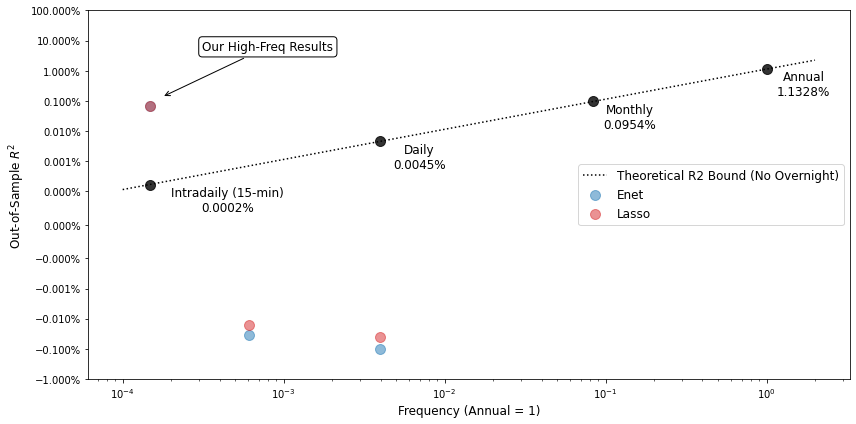

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))

## Theoretical limits
# Add line across frequencies
# plt.plot(
#     np.linspace(1e-4, 2, 110000),
#     [get_theoretical_r2(x) for x in np.linspace(1e-4, 2, 110000)],
#     color="k",
#     ls="--",
#     alpha = 0.8,
#     label='Theoretical R2 Bound',
# )
plt.plot(
    np.linspace(1e-4, 2, 110000),
    [
        get_theoretical_r2(x, true_annual_mean=0.0152, true_annual_stdev=0.142)
        for x in np.linspace(1e-4, 2, 110000)
    ],
    color="k",
    ls=":",
    label="Theoretical R2 Bound (No Overnight)",
)

# Add points for specific frequencies
for delta_n, freq in zip(
    [1, 1 / 12, 1 / 12 / 21, 1 / 12 / 21 / 27],
    ["Annual", "Monthly", "Daily", "Intradaily (15-min)"],
):

    plt.scatter(
        [delta_n],
        [get_theoretical_r2(delta_n, true_annual_mean=0.0152, true_annual_stdev=0.142)],
        marker="o",
        s=100,
        color="k",
        zorder=3,
        alpha=0.8,
        label=None,
    )
    plt.text(
        delta_n * 1.7 + 0.0002,
        get_theoretical_r2(delta_n, true_annual_mean = 0.0152, true_annual_stdev = 0.142) * 0.9,
        f"{freq}\n{get_theoretical_r2(delta_n, true_annual_mean = 0.0152, true_annual_stdev = 0.142):.4%}",
        ha="center",
        va="top",
        fontdict={"fontsize": 12},
    )

## Results
# Our results
for model in ['Enet', 'Lasso']:
    
    if model == 'Enet':
        color = 'tab:blue'
    else:
        color = 'tab:red'
    
    plt.scatter(
        [1 / 12 / 21 / 27] * 1,
        metrics_hf_df.loc[[model]]["R2_oss"],
        s=100,
        color = color,
        alpha=0.5,
        label=model,
    )

    plt.scatter(
        [1 / 12 / 21 / 6.5] * 1,
        metrics_hourly_df.loc[[model]]["R2_oss"],
        s=100,
        color=color,
        alpha=0.5,
    )
    plt.scatter(
        [1 / 12 / 21] * 1,
        metrics_daily_df.loc[[model]]["R2_oss"],
        s=100,
        color=color,
        alpha=0.5,
    )
    
ax.annotate(
    "Our High-Freq Results",
    xy=(1.2 / 12 / 21 / 27, 2*metrics_hf_df["R2_oss"]["Enet"]),  # (1, 0.5) of the an1's bbox
    xytext=(40, 50),
    textcoords="offset points",
    va="center",
    ha="left",
    fontsize=12,
    bbox=dict(boxstyle="round", fc="w"),
    arrowprops=dict(arrowstyle="->"),
)

plt.legend(fontsize=12, loc="center right")
plt.yscale("symlog", linthresh=1e-6)
plt.xscale("log")

plt.ylim(-0.01, 1)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=3))

ax.set_xlabel("Frequency (Annual = 1)", fontsize=12)
ax.set_ylabel("Out-of-Sample $R^2$", fontsize=12)
plt.tight_layout()
plt.savefig("../../docs/exhibits/figures/rsquared_versus_frequency.pdf")

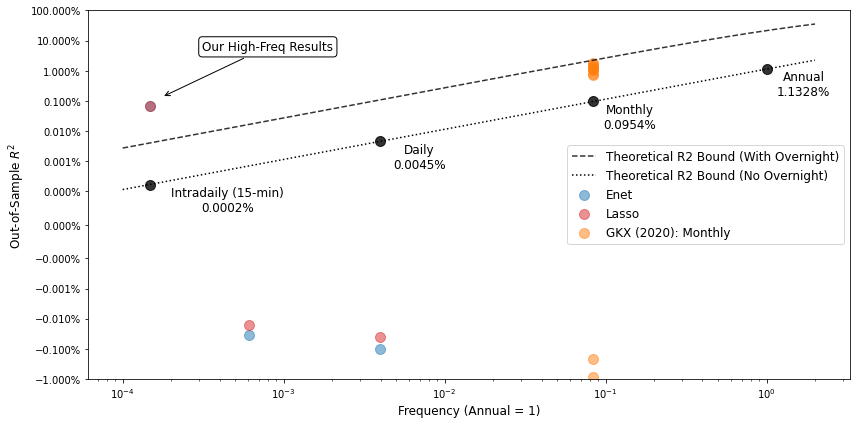

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

## Theoretical limits
# Add line across frequencies
plt.plot(
    np.linspace(1e-4, 2, 110000),
    [get_theoretical_r2(x) for x in np.linspace(1e-4, 2, 110000)],
    color="k",
    ls="--",
    alpha = 0.8,
    label='Theoretical R2 Bound (With Overnight)',
)
plt.plot(
    np.linspace(1e-4, 2, 110000),
    [get_theoretical_r2(x, true_annual_mean = 0.0152, true_annual_stdev = 0.142) for x in np.linspace(1e-4, 2, 110000)],
    color="k",
    ls=":",
    label='Theoretical R2 Bound (No Overnight)',
)

# Add points for specific frequencies
for delta_n, freq in zip(
    [1, 1 / 12, 1 / 12 / 21, 1 / 12 / 21 / 27],
    ["Annual", "Monthly", "Daily", "Intradaily (15-min)"],
):

    plt.scatter(
        [delta_n],
        [get_theoretical_r2(delta_n, true_annual_mean=0.0152, true_annual_stdev=0.142)],
        marker="o",
        s=100,
        color="k",
        zorder=3,
        alpha=0.8,
        label=None,
    )
    plt.text(
        delta_n * 1.7 + 0.0002,
        get_theoretical_r2(delta_n, true_annual_mean = 0.0152, true_annual_stdev = 0.142) * 0.9,
        f"{freq}\n{get_theoretical_r2(delta_n, true_annual_mean = 0.0152, true_annual_stdev = 0.142):.4%}",
        ha="center",
        va="top",
        fontdict={"fontsize": 12},
    )

## Results
# Our results
for model in ['Enet', 'Lasso']:
    
    if model == 'Enet':
        color = 'tab:blue'
    else:
        color = 'tab:red'
    
    plt.scatter(
        [1 / 12 / 21 / 27] * 1,
        metrics_hf_df.loc[[model]]["R2_oss"],
        s=100,
        color = color,
        alpha=0.5,
        label=model,
    )

    plt.scatter(
        [1 / 12 / 21 / 6.5] * 1,
        metrics_hourly_df.loc[[model]]["R2_oss"],
        s=100,
        color=color,
        alpha=0.5,
    )
    plt.scatter(
        [1 / 12 / 21] * 1,
        metrics_daily_df.loc[[model]]["R2_oss"],
        s=100,
        color=color,
        alpha=0.5,
    )
    
ax.annotate(
    "Our High-Freq Results",
    xy=(1.2 / 12 / 21 / 27, 2*metrics_hf_df["R2_oss"]["Enet"]),  # (1, 0.5) of the an1's bbox
    xytext=(40, 50),
    textcoords="offset points",
    va="center",
    ha="left",
    fontsize=12,
    bbox=dict(boxstyle="round", fc="w"),
    arrowprops=dict(arrowstyle="->"),
)

# Xiu
gkx_results = np.array([-0.22, -0.86, -1.55, 0.75, 0.71, 1.37, 1.40, 1.08, 1.13, 1.80, 1.63, 1.17])/100
plt.scatter(
    [1 / 12 ] * len(gkx_results),
    gkx_results,
    s=100,
    color = 'tab:orange',
    alpha=0.5,
    label="GKX (2020): Monthly",
)


plt.legend(fontsize=12, loc = 'center right')
plt.yscale("symlog", linthresh=1e-6)
plt.xscale("log")

plt.ylim(-0.01, 1)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=3))

ax.set_xlabel("Frequency (Annual = 1)", fontsize = 12)
ax.set_ylabel('Out-of-Sample $R^2$', fontsize = 12)
plt.tight_layout()
plt.savefig('../../docs/exhibits/figures/rsquared_versus_frequency_with_literature.pdf')

# Simulation

In [8]:
mkt_returns_oos_df = fret_df['ff__mkt']
mkt_returns_oos_intradaily_df = mkt_returns_oos_df.loc[
    mkt_returns_oos_df.index.time != dt.time(9, 30)
]
print(
    "Intradaily average return (annualized): ",
    mkt_returns_oos_intradaily_df.groupby(pd.Grouper(freq="1y")).sum().mean(),
)
print(
    "Intradaily average vol (annualized):    ",
    np.sqrt(
        mkt_returns_oos_intradaily_df.pipe(np.square).groupby(pd.Grouper(freq="1y")).sum()
    ).mean(),
)

Intradaily average return (annualized):  0.010678885864777596
Intradaily average vol (annualized):     0.1334104027402623


In [68]:
for delta_n, freq in zip(
    [1, 1 / 12, 1 / 12 / 21, 1 / 12 / 21 / 26], ["Annual", "Monthly", "Daily", "Intradaily"]
):

    print(f"[{freq}]")
    n = int(1e7)
    mean = delta_n * 0.010678885864777596 
    std = np.sqrt(delta_n) * 0.1334
    X = np.random.normal(mean, std, n)
    print(f"MonteCarlo: {1 - np.sum(np.square(X-mean)) / np.sum(np.square(X))}")
    print(f"Analytical: { 1 - std**2 / (mean**2 + std**2)}")
    print()

[Annual]
MonteCarlo: 0.006333741564785278
Analytical: 0.006367457241160612

[Monthly]
MonteCarlo: 0.0005236127145047398
Analytical: 0.0005337367706563789

[Daily]
MonteCarlo: 2.8982591822601655e-05
Analytical: 2.5428962767026775e-05

[Intradaily]
MonteCarlo: 9.241881750998715e-07
Analytical: 9.780609440124266e-07



In [69]:
# For all returns
for delta_n, freq in zip([1, 1/12, 1/12/21, 1/12/21/27], ['Annual', 'Monthly', 'Daily', 'Intradaily']):

    print(f'[{freq}]')
    n = int(1e7)
    mean = delta_n * 0.094
    std = np.sqrt(delta_n) * 0.166
    X = np.random.normal(mean, std, n)
    print(f'MonteCarlo: {1 - np.sum(np.square(X-mean)) / np.sum(np.square(X))}')
    print(f'Analytical: { 1 - std**2 / (mean**2 + std**2)}')
    print()

[Annual]
MonteCarlo: 0.24308621095887262
Analytical: 0.2428006155198945

[Monthly]
MonteCarlo: 0.026229077602697548
Analytical: 0.026025896296994477

[Daily]
MonteCarlo: 0.0013052277834214587
Analytical: 0.0012708278560402686

[Intradaily]
MonteCarlo: 4.305734059351085e-05
Analytical: 4.7125368520251065e-05



# R2 Over Time

## Params

In [34]:
## Params
# List of all results folders
results_folders = (
    pd.read_excel("../../results/key.xlsx").query('"Done" in Notes')["Folder"].to_list()
) 

# Year to start trading
start_year = "2004"

# Define strategies and models
model_list = ["Benchmark", "LR", "LR_PCA_select", "LR_Lasso_select", "Lasso", "Enet"]

# Latex table params
table_loc = "!h"  # Should be something like htbp
table_fontsize = "footnotesize"
table_precaption = "Performance Results"
table_output_folder = "../../docs/exhibits/tables"

# Metrics and their names
metrics_list = ["Return", "ReturnAdj", "Sharpe", "SharpeAdj", "Trades", "rvol"]
metrics_names_list = [
    "Return",
    "Adjusted Return",
    "Sharpe",
    "Adjusted Sharpe",
    "Trades",
    "Realized Volatility",
]

## Functions

In [35]:
def compute_rsquared(truth, pred):
    return 1 - np.sum(np.square(truth-pred))/np.sum(np.square(truth))

In [165]:
def plot_rsquared(forecast_oss_filter_df, fret_filter_df, freq = '3m'):

    fig, ax = plt.subplots(figsize=(10, 5))

    # Compute monthly R2
    resid_df = forecast_oss_filter_df.subtract(fret_filter_df["ff__mkt"], axis=0)
    r2_monthly_df = 1 - resid_df.pipe(np.square).groupby(pd.Grouper(freq=freq)).sum().divide(
        fret_filter_df["ff__mkt"].pipe(np.square).groupby(pd.Grouper(freq=freq)).sum(), axis=0
    )

    sns.lineplot(
        x="datetime",
        y="value",
        hue="variable",
        data=r2_monthly_df.melt(ignore_index=False).reset_index(),
        palette="Set2",
        lw=2,
        ax=ax,
    )
    ax.axhline(0, color="k", ls="--", alpha=0.5, zorder=-1)

    # Highlight recessions
    ax.axvspan(pd.to_datetime("2007-12-01"), pd.to_datetime("2009-06-01"), color="k", alpha=0.05)
    ax.axvspan(pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-01"), color="k", alpha=0.05)

    # Other settings
    ax.set_xlabel(None)
    ax.set_ylabel("R-Squared")
    ax.legend(loc="upper left")
    ax.set_ylim(-0.01, 0.01)

    plt.tight_layout()
    
    return fig, ax

## Main

In [168]:
for folder_name in tqdm(results_folders):

    ### Prep
    ## Get forecast data
    forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
        folder_name=folder_name,
        debug=True,
    )

    # Model list?
    model_list = [
        x.replace("oss_", "") for x in forecast_oss_df.columns if "NN" not in x
    ]  ###################### <----- Remove this !!

    ## Get trading results
    # Filter data
    forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
    forecast_ins_filter_df = forecast_ins_df.loc[start_year:].copy()
    fret_filter_df = fret_df.loc[start_year:].copy()
    hrf_filter_df = hrf_df.loc[start_year:].copy()
    
    # Get overlapping indices
    intersect_idx = list(set(forecast_oss_filter_df.index).intersection(fret_filter_df.index))
    forecast_oss_filter_df = forecast_oss_df.loc[intersect_idx].copy()
    forecast_ins_filter_df = forecast_ins_df.loc[intersect_idx].copy()
    fret_filter_df = fret_df.loc[intersect_idx].copy()
    hrf_filter_df = hrf_df.loc[intersect_idx].copy()
    
    fig, _ = plot_rsquared(forecast_oss_filter_df, fret_filter_df, freq = '3m')
    fig.savefig(
        f"../../docs/exhibits/figures/rsquared_over_time_{results_folder_name}.pdf"
    )
    plt.close()

  0%|          | 0/8 [00:00<?, ?it/s]

## Latex

In [175]:
print(r"\section{RSquared Over Time}")

for folder_name in tqdm(results_folders):

    results_folder_name = folder_name
    filename = f"../../docs/exhibits/figures/rsquared_over_time_{results_folder_name}.pdf"
    fig_label = 'return_timing_' + results_folder_name
                

    latex_str = (
r"""
\begin{figure}[""" + table_loc + r"""]
\caption{Intradaily $R^2$ over Time -- """ + folder_name.replace("_", " ").title() + r"""}  
\label{fig:""" + fig_label + r"""}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
\includegraphics[width=0.99\linewidth]{"""
+ filename
+ r"""} \\
\multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} For each of our models and every quarter in our sample, we compute and plot the out-of-sample $R^2$ using intradaily returns.  }     \\  
\end{tabular}
\end{figure}
"""
    )
    print(latex_str)

    # print("\n\\clearpage\n")

\section{RSquared Over Time}


  0%|          | 0/8 [00:00<?, ?it/s]


\begin{figure}[!h]
\caption{Intradaily $R^2$ over Time -- Main}  
\label{fig:return_timing_main}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
\includegraphics[width=0.99\linewidth]{../../docs/exhibits/figures/rsquared_over_time_main.pdf} \\
\multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} For each of our models and every quarter in our sample, we compute and plot the out-of-sample $R^2$ using intradaily returns.  }     \\  
\end{tabular}
\end{figure}


\begin{figure}[!h]
\caption{Intradaily $R^2$ over Time -- Main Combined}  
\label{fig:return_timing_main_combined}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
\includegraphics[width=0.99\linewidth]{../../docs/exhibits/figures/rsquared_over_time_main_combined.pdf} \\
\multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} For each of our models and every quarter in our sample, we compute and plot the out-of-sample $R^2$ using intradaily returns.  }     \\

# Scratch

In [27]:
def check_r2(predictors):
    
    # Load data
    forecast_oss_df, forecast_ins_df, _ = results_tools.load_model_results(overnight=False, oos_periods=2, debug = True, predictors = predictors)
    fret_df, hrf_df = results_tools.load_mkt_rf_returns()
    spread_df = results_tools.load_spreads()

    def compute_rsquared(truth, pred):
        return 1 - np.sum(np.square(truth-pred))/np.sum(np.square(truth))

    # Get true values
    forecast_oss_df["truth"] = fret_df["ff__mkt"]
    forecast_ins_df["truth"] = fret_df["ff__mkt"]
    
    # Filter
    forecast_oss_df = forecast_oss_df.loc['2004':]
    forecast_ins_df = forecast_ins_df.loc['2004':]
    fret_df = fret_df.loc['2004':]

    # Set up dataframe with metrics
    model_names = [
        x for x in ["_".join(col.split("_")[1:]) for col in forecast_oss_df.columns] if len(x) > 0
    ]
    metrics_df = pd.DataFrame([], index=model_names)

    # Fill in R2 estimates
    for col in model_names:
        metrics_df.loc[col, "R2_ins"] = compute_rsquared(
            forecast_ins_df["truth"], forecast_ins_df["ins_" + col]
        )
        metrics_df.loc[col, "R2_oss"] = compute_rsquared(
            forecast_oss_df["truth"], forecast_oss_df["oss_" + col]
        )

    metrics_df = metrics_df.applymap(lambda x: np.nan if np.abs(x) > 10 else x)
    metrics_df["R2_diff"] = metrics_df["R2_oss"] - metrics_df["R2_ins"]

    fig, ax = plt.subplots(figsize=(5, 3))
    sns.heatmap(
        metrics_df,
        cmap="viridis",
        vmin=-0.1 / 100,
        center=0,
        vmax=0.1 / 100,
        annot=True,
        fmt=".3%",
        annot_kws={"fontsize": 14},
    )

Loading the following model results...
--------------------------------------------------
Folder         main
Overnight     False
OOSPeriods        2
Predictors      All
Notes          Done
--------------------------------------------------
Loading the following model results...
--------------------------------------------------
Folder        main_combined
Overnight             False
OOSPeriods                2
Predictors         Combined
Notes                  Done
--------------------------------------------------
Loading the following model results...
--------------------------------------------------
Folder          main_cts
Overnight          False
OOSPeriods             2
Predictors    Continuous
Notes               Done
--------------------------------------------------
Loading the following model results...
--------------------------------------------------
Folder        main_jmp
Overnight        False
OOSPeriods           2
Predictors        Jump
Notes             Done
-------

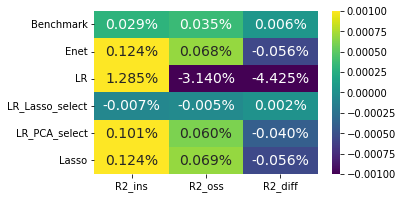

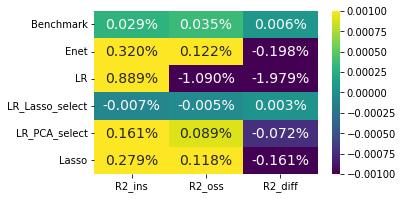

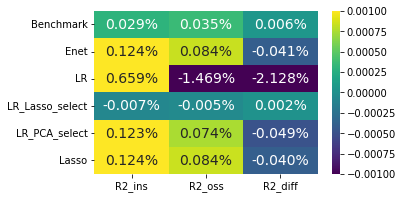

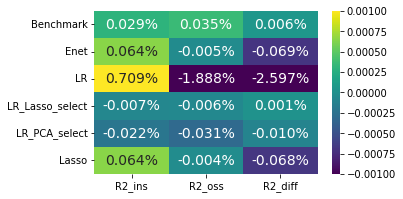

In [28]:
check_r2('All')
check_r2('Combined')
check_r2('Continuous')
check_r2('Jump')